# Grading students' submissions

## Overall solution
The CLI interface for the autograder works only with docker containers.  
If we want to grade without containers, we will need to use other means.

In this notebook, we use the `grade_submission` API.  

**Limitations:** this method is sequential and may take a lot of time if there are lots of submission

## Grading process

* Step 1: grade the individual submissions, possibility to generate 2 CSV files for each student: 1 with the overall grade and 1 with the detailed grading
* Step 2: fill out the individual CSV from moodle for each student
* Step 3: concatenate all moodle CSV files into 1 global gradebook

## Grading utility functions

**TODO**: look at grades vs. points - computation seems complex with multiple cases depending where the points are specified (at level of question or tests or test)  
**TODO**: should we allow to display test messages without the details of the points (or only if tests have passed or failed) ?

In [1]:
from grading_utils import *

## Grading and generation of the output

### First retrieving the grader

In [2]:
# Folder in which the assignment and grader has been generated
distributionfolder = "dist"

# Name of the assignment **file**
assignmentname = "assignment"

# Retrieving the grader zip
graderzip = glob.glob(distributionfolder+"/autograder/"+assignmentname+"-autograder_*.zip")[0]
graderzip

'dist/autograder/assignment-autograder_2023_01_25T15_36_47_457735.zip'

### Then retrieving students' submission folders

In [3]:
# Folder in which to find students' submission folders
allsubmissionsfolder = "moodlesubmissions/"

# Listing all the submissions (folders)
submissionlist = glob.glob(allsubmissionsfolder+"/*/")
submissionlist

['moodlesubmissions/testassignment_course15917_student888043_submission583808_Pierre-Olivier_Vallès/',
 'moodlesubmissions/testassignment_course15917_student9_submission583892_Patrick_Jermann/']

### Iterating over submissions, calling the grader and storing the results into CSV files  

**TO EXPLORE**: why does the cell returns the graphs generated by students? how can we avoid this?

CPU times: user 975 ms, sys: 125 ms, total: 1.1 s
Wall time: 1.21 s


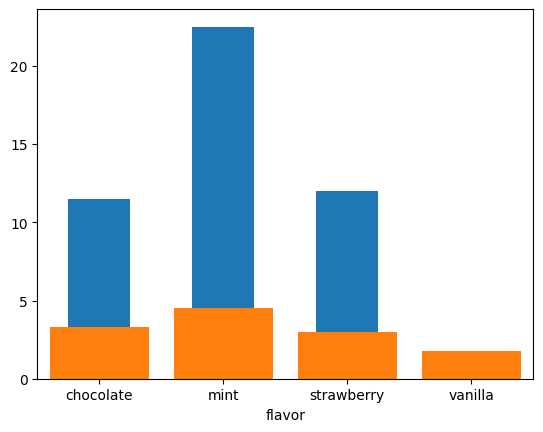

In [4]:
%%time

# Folder where to find the moodle grading sheets
moodlegradingsheetfolder = "gradebook"

# List of generated moodle data
moodledata = []

# Iterating over submission folders
for submissionfolder in submissionlist:
    
    # Finding the notebook to grade, using recursive exploration ("**/" pattern + recursive=True) to go across potential subfolders /!\ WATCH OUT for execution time...
    submissionfile = glob.glob(submissionfolder+"**/"+assignmentname+".ipynb", recursive=True)[0] # TODO here do some error management
    #print(submissionfile)
    
    # Grading the individual notebook
    graderresultdf, graderdetailsdf = grade_and_writeCSV(submissionfile, graderzip, submissionfolder+"/"+moodlegradingsheetfolder, includetestcasemessages=True)
    #display(graderresultdf)
    #display(graderdetailsdf)
    
    # Reading and updating the associated moodle CSV file for this notebook
    moodlegradebookfile = glob.glob(submissionfolder+"/"+moodlegradingsheetfolder+"/*_grading.csv")[0] # TODO here do some error management
    moodledf = write_moodleCSV(moodlegradebookfile, graderresultdf, graderdetailsdf)
    #display(moodledf)
    
    # Collecting all individual moodle information to build the global moodle file
    moodledata.append(moodledf)

**/!\ If the assignment needs some manual grading**: the instructor should go over the individual files and edit the CSV files to update the grades.
In that case, the script generating the overall grading sheet should read the updated CSV files instead of working with the list of dataframes...  
**TODO** think about a solution

### Agregating all the results into 1 CSV file for import in moodle

In [5]:
# Saving all the moodle data to a general moodle CSV grading sheet
moodledatadf = pd.concat(moodledata)
#display(moodledata)
moodledatadf.to_csv(allsubmissionsfolder+"/"+"overall_grading.csv", index=False, quoting=csv.QUOTE_NONNUMERIC); # The quotes are important for the file to be read by moodle